# T-Maze Perception-Action Cycle with Generalized FE

In [1]:
using Pkg
Pkg.activate(".")
# Pkg.instantiate()

  Activating project at `c:\Simulations\EpistemicMessagePassing\src\Part2\Rx`


In [2]:
using RxInfer, LinearAlgebra, Plots

# T-maze layout
# [2| |3]
#   | |
#   |1|
#   |4|

## Agent

In [3]:
include("goal_observation.jl")

# Define the generative model
@model function t_maze(A_s, D_s, x)
    u = datavar(Matrix{Int64}, 2) # Policy for evaluations
    z = randomvar(2) # Latent states
    c = datavar(Vector{Float64}, 2) # Goal prior statistics

    z_0 ~ Categorical(D_s) # State prior
    A ~ MatrixDirichlet(A_s) # Observation matrix prior

    z_k_min = z_0
    for k=1:2
        z[k] ~ Transition(z_k_min, u[k])
        c[k] ~ GoalObservation(z[k], A) where {
            meta=GeneralizedMeta(x[k]), 
            pipeline=GeneralizedPipeline(vague(Categorical,8))} # With breaker message

        z_k_min = z[k] # Reset for next slice
    end
end

# Define constraints on the variational density
@constraints function structured(approximate::Bool)
    q(z_0, z, A) = q(z_0, z)q(A)
    if approximate # Sampling approximation on parameter required for t<3
        q(A) :: SampleList(20)
    end
end

structured (generic function with 1 method)

## Simulation

In [4]:
# Define experimental setting
α = 0.9; c = 2.0 # Reward probability and utility
S = 100 # Number of trials
seed = 666 # Randomizer seed

include("helpers.jl")
include("environment.jl")
include("agent.jl")

(A, B, C, D) = constructABCD(α, c)
(A_0, D_0) = constructPriors() # Construct prior statistics for A and D

rs = generateGoalSequence(seed, S) # Sets random seed and returns reproducible goal sequence
(reset, execute, observe) = initializeWorld(A, B, C, D, rs) # Let there be a world
(infer, act) = initializeAgent(A_0, B, C, D_0) # Let there be a constrained agent

# Step through the experimental protocol
As = Vector{Matrix}(undef, S) # Posterior statistics for A
Gs = [Vector{Matrix}(undef, 3) for s=1:S] # Free energy values per time
as = [Vector{Int64}(undef, 2) for s=1:S] # Actions per time
os = [Vector{Vector}(undef, 2) for s=1:S] # Observations (one-hot) per time
for s = 1:S
    reset(s) # Reset world
    for t=1:2
        (Gs[s][t], _) = infer(t, as[s], os[s])
             as[s][t] = act(t, Gs[s][t])
                        execute(as[s][t])
             os[s][t] = observe()
    end
    (Gs[s][3], As[s]) = infer(3, as[s], os[s]) # Learn at t=3
end
;

## Results

In [5]:
sum([as[s].==rs[s]'*[2, 3] for s=1:S]) # Correct visits per timepoint

2-element Vector{Int64}:
  0
 99

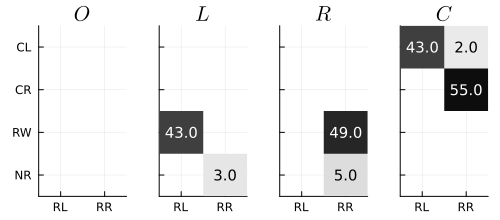

In [15]:
include("visualizations.jl")
plotObservationStatistics(As[S], A_0)
# savefig("figures/GFE_A")

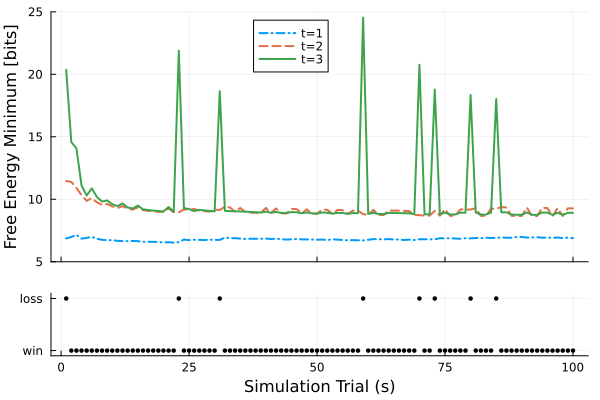

In [16]:
include("visualizations.jl")
plotFreeEnergyMinimum(Gs, os, legend=100, ylim=(5,25))
# savefig("figures/GFE_FE.png")

In [8]:
# include("visualizations.jl")
# for s=1:S
#     plotFreeEnergies(Gs[s], as[s], os[s], rs[s], title="s=$s")
#     savefig("figures/GFE_$s.png")
# end